In [1]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

The following additional packages will be installed:
  libxtst6 openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra fonts-nanum fonts-ipafont-gothic
  fonts-ipafont-mincho fonts-wqy-microhei fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  libxtst6 openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 3 newly installed, 0 to remove and 49 not upgraded.
Need to get 39.6 MB of archives.
After this operation, 144 MB of additional disk space will be used.
Selecting previously unselected package libxtst6:amd64.
(Reading database ... 123629 files and directories currently installed.)
Preparing to unpack .../libxtst6_2%3a1.2.3-1build4_amd64.deb ...
Unpacking libxtst6:amd64 (2:1.2.3-1build4) ...
Selecting previously unselected package openjdk-8-jre-headless:amd64.
Preparing to unpack .../openjdk-8-jre-headless_8u422-b05-1~22.04_amd64.deb ...
Unpacking openjdk-8-jre-headless:amd64 (8u422-b05-1~22.04) ...
Sel

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pyspark
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

In [27]:
# create the session
conf = SparkConf().set("spark.ui.port", "4050")

# create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

In [29]:
def parseVector(line):
  return np.array([float(x) for x in line.split(" ")])

def closestPoint(p, centroids, method = 'd2'):
  bestIndex = -1
  distance = float("+inf")
  for i in range(len(centroids)):
    if method == 'd2':
      temp_distance = np.sum((p - centroids[i]) ** 2)
    elif method == 'd1':
      temp_distance = np.sum(np.abs(p - centroids[i]))

    if temp_distance < distance:
      distance = temp_distance
      bestIndex = i

  return bestIndex, distance

In [30]:
data = spark.read.text('data.txt').rdd.map(lambda x: x[0]).map(parseVector)
c1 = np.loadtxt('c1.txt', delimiter = ' ')
c2 = np.loadtxt('c2.txt', delimiter = ' ')
MAX_ITER = 20
centroids1 = c1.copy()
centroids2 = c2.copy()

error_c1_Euclidean_distance = []
error_c2_Euclidean_distance = []

for ITER in range(MAX_ITER):
  closest = data.map(lambda p: (closestPoint(p, centroids1, 'd2')[0], (p, 1, closestPoint(p, centroids1, 'd2')[1])))
  pointStats = closest.reduceByKey(lambda p1_c1, p2_c2: (p1_c1[0] + p2_c2[0], p1_c1[1] + p2_c2[1]))
  newCentroids = pointStats.map(lambda st: (st[0], st[1][0] / st[1][1])).collect()

  error = np.sum(np.array(list(x[1][2] for x in closest.collect())))
  error_c1_Euclidean_distance.append(error)

  for (i, p) in newCentroids:
    centroids1[i] = p

for ITER in range(MAX_ITER):
  closest = data.map(lambda p: (closestPoint(p, centroids2, 'd2')[0], (p, 1, closestPoint(p, centroids2, 'd2')[1])))
  pointStats = closest.reduceByKey(lambda p1_c1, p2_c2: (p1_c1[0] + p2_c2[0], p1_c1[1] + p2_c2[1]))
  newCentroids = pointStats.map(lambda st: (st[0], st[1][0] / st[1][1])).collect()

  error = np.sum(np.array(list(x[1][2] for x in closest.collect())))
  error_c2_Euclidean_distance.append(error)

  for (i, p) in newCentroids:
    centroids2[i] = p

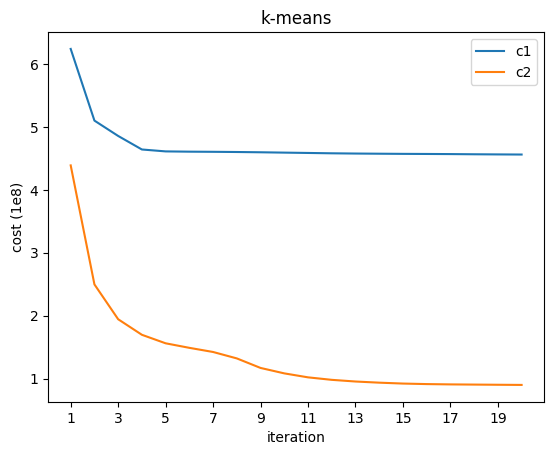

The percentage change in c1 by using Euclidean distance is :0.2648391714456054
The percentage change in c2 by using Euclidean distance is :0.7669795594605942


In [31]:
plt.figure()
plt.plot(list(range(1, 21)), np.array(error_c1_Euclidean_distance) / 100000000, label ='c1')
plt.plot(list(range(1, 21)), np.array(error_c2_Euclidean_distance) / 100000000, label = 'c2')
plt.xticks(list(range(1, 21, 2)))
plt.xlabel('iteration')
plt.ylabel('cost (1e8)')
plt.title('k-means')
plt.legend(['c1', 'c2'])
plt.savefig('Euclidean_dist.png')
plt.show()
print("The percentage change in c1 by using Euclidean distance is :{}".format((error_c1_Euclidean_distance[0] - error_c1_Euclidean_distance[10]) / error_c1_Euclidean_distance[0]))
print("The percentage change in c2 by using Euclidean distance is :{}".format((error_c2_Euclidean_distance[0] - error_c2_Euclidean_distance[10]) / error_c2_Euclidean_distance[0]))

In [32]:
sc.stop()